# Selecting Blazhko candidates

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# Basic libraries
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

In [4]:
plt.rcParams.update({
    'font.serif': 'Andale Mono',
    'font.family': 'serif'
})

In [5]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*
from BE_plotting import*

---

*Authors: Ema Donev and dr. Ivezić*

In this notebook we tackle the selection of Blazhko candidates via an algorithm we designed, followed by visual analysis of all the candidates with their phase graphs, periodograms, total observation plot and a seasonal plot. We look for signs of amplitude or phase modulation, marks of the Blazhko effect.  

In [6]:
# DATA
# ======
# LINEAR data
dataL = fetch_LINEAR_sample(data_home='../inputs')

# calcualted data
end = 'ffinal'

# light curve table
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
# rr lyrae
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
# periodogram data
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
# fits data
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
# ztf data
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [7]:
print(lc_analysis.shape)
lc_analysis.head()

(2857, 34)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7952,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5545,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.8840,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4821,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1860,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN


---

# Creating a selection algorithm

We wanted our selection algorithm to take into account quantitative information about each star pair, select it for a potential Blazhko candidate if it is deemed so and then later we would comence visual or qualitative analysis to confirm the algorithms selection.

#### 1. Removing obvious bad candidates

The first step was to determine boundaries for each quality of a star pair where the algorithm would deem the star impossible to be blazhko, possibly even rr_lyrae. We call these "bad candidates". Qualities of interest for each star pair are as such:
- number of data points (both LINEAR and ZTF)
- period, difference in period and ratio between periods (between LINEAR and ZTF)
- amplitude difference between a star pair, and the individual amplitudes as well
- robust $\chi^2$ values (LINEAR and ZTF)
- calculated Blazhko period
- calculated strength and significance of blazhko peak

From these values, we conclude that:
- the difference in amplitude for an individual star in a star pair must be smaller than 2 magnitudes, otherwise we are not looking at a variable star
- both periods must be within the range for RR Lyrae, so less than 4 days
- number of data points for LINEAR and ZTF have a certain cutoff point dictated by a plot, if we have too few datapoints we cannot draw conclusions
- finally, the ratio of periods must be reasonable (from 0.8 to 1.2), as any higher indicates that LINEAR coordinates led to the wrong ZTF star pair.

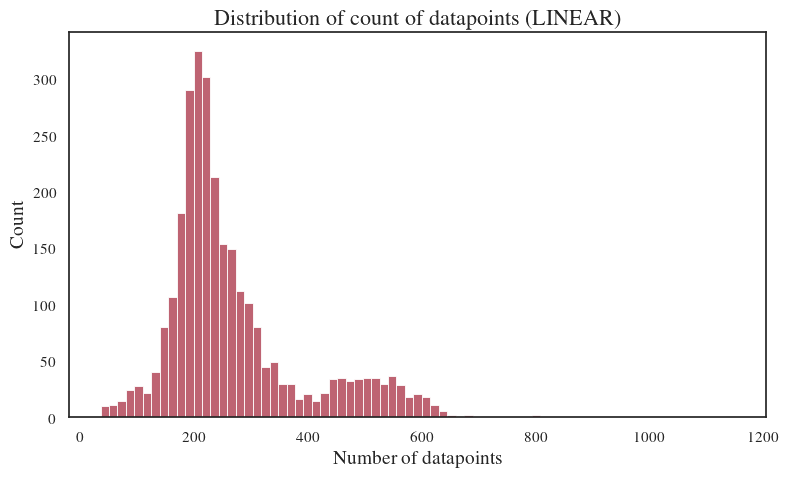

In [8]:
plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['NdataLINEAR'].to_numpy(), color=or1)
plt.title('Distribution of count of datapoints (LINEAR)',fontproperties=font,fontsize=16)
plt.xlabel('Number of datapoints', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.show()

From the plot we notice 2 peaks in the distribution, and we see that most LINEAR stars have a satisfactory amount of datapoints, with the peak being at around 220 datapoints. We then conclude that our cutoff point is **200 datapoints**.

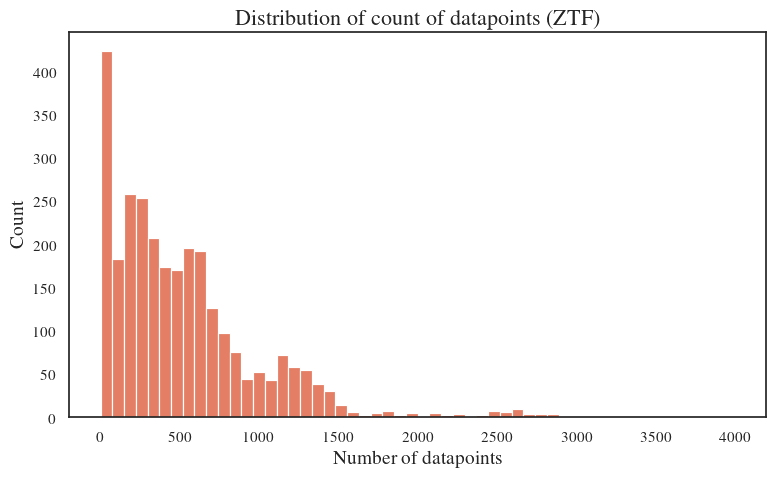

In [9]:
plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['NdataZTF'].to_numpy(), color=or3)
plt.title('Distribution of count of datapoints (ZTF)',fontproperties=font,fontsize=16)
plt.xlabel('Number of datapoints', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.show()

For ZTF data is an entirely different situation. Here, we notice that many stars have a very low amount of data, however the range is much higher than that of LINEAR. In order to gain a similar amount of ZTF stars with a satisfactory amount of datapoints, we would decide our cutoff point to be at around **150 datapoints**.

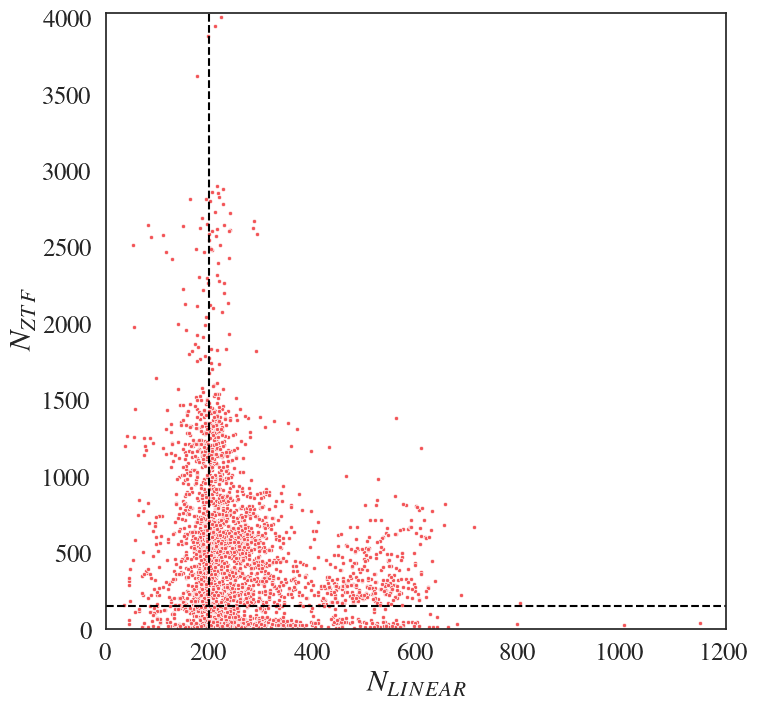

In [10]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(xscale='linear', yscale='linear') 
ax.xaxis.set_tick_params(labelsize=18) 
ax.yaxis.set_tick_params(labelsize=18) 
plt.rc('font', size=24) 


sns.scatterplot(data=lc_analysis, x='NdataLINEAR', y='NdataZTF', marker='.', color=or4)
plt.xlim([0, 1200])
plt.ylim([0, 4030])
plt.xlabel(r'$N_{LINEAR}$', fontproperties=font, fontsize=22)
plt.ylabel(r'$N_{ZTF}$', fontproperties=font,fontsize=22)
plt.plot([200, 200], [0, 4030], ls='--', c='black')
plt.plot([0, 1200], [150, 150], ls='--', c='black')
plt.savefig('../images_paper/number_of_points_cutoff.png', dpi=200)
plt.show()

---

### 2. Structure of algorithm

After we have determined which stars are not even viable for Blazhko selection, we need to create an algorithm which selects the ones that do. This means that we now need to quantitatively analyze the $\chi^2$ values, period difference between LINEAR and ZTF, and the presence of the effect via the periodogram.

The algorithm would now be divided into 2 parts. The first part checks for viability of Blazhko effect via the periodogram. Here we look at the significance of the Blazhko peak, strength and blazhko period values. If a star **passes all the tests for periodogram analysis, it is immediately considered a Blazhko candidate**.

If a star fails even one of these requirements, it proceeds to the next phase, where we analyze its other properties: amplitude, period and $\chi^2$ via a scoring mechanism.

For this step, we select the **period difference**, or $(P_l - P_z)/P_{mean}$, the amplitude difference between LINEAR and ZTF, and finally the *robust $\chi^2$ values for both datasets.

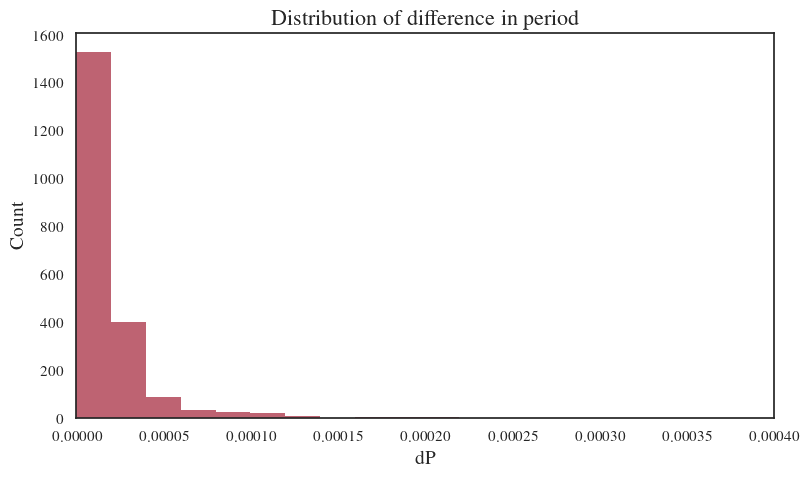

In [11]:
plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['dP'].to_numpy(), bins=100000,color=or1)
plt.xlim([0,0.0004])
plt.title('Distribution of difference in period',fontproperties=font,fontsize=16)
plt.xlabel('dP', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../images_paper/hist_dP.png', dpi=200)
plt.show()

From this graph we can see that most star pairs have a really small period difference, hence we shouldn't have a very large cutoff point.
- $0.00002 < dP < 0.00005$ => 2 points
- $dP < 0.00005$ => 4 points

For the amplitude values, since most amplitude changes are quite minor, we can develop boundaries as such:
- $0.05< ampl <0.15$ - 1 point
- $0.15 < ampl < 1$ - 2 points

We have put a boundary on the amplitude difference between both stars to be 1 mag, as a difference of 2.5 times brightness between the same star is highly unlikely.

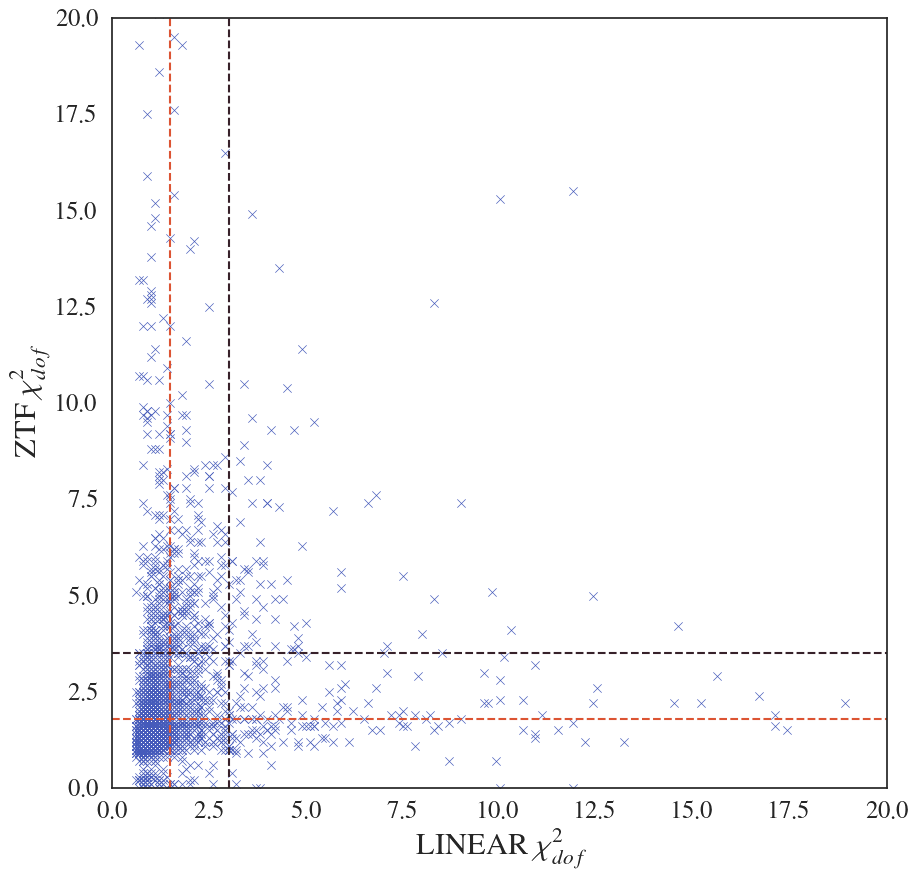

In [12]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(xscale='linear', yscale='linear') 
ax.xaxis.set_tick_params(labelsize=18) 
ax.yaxis.set_tick_params(labelsize=18) 
plt.rc('font', size=24) 


sns.scatterplot(data=lc_analysis, x='L_chi2dofR', y='Zchi2dofR', marker='x', color=b1)
plt.xlim([0, 20]) # limit of 20, because above 20 there is no point, something is wrong with the data
plt.ylim([0, 20])
plt.xlabel(r'LINEAR $\chi_{dof}^2$', fontproperties=font, fontsize=22)
plt.ylabel(r'ZTF $\chi_{dof}^2$', fontproperties=font,fontsize=22)

plt.plot([1.5, 1.5], [0, 20], ls='--', c=or3)
plt.plot([3.0, 3.0], [0, 20], ls='--', c=black1)
plt.plot([0, 20.0], [1.8, 1.8], ls='--', c=or3)
plt.plot([0, 20.0], [3.5, 3.5], ls='--', c=black1)
plt.savefig('../images_paper/chi2_cutoff_counting.png', dpi=300)
plt.show()

- $1.5< \chi^2_L < 3.0$  AND $\chi^2_Z < 1.8$ - 2 points
- $1.8 < \chi^2_Z < 3.5$ AND $\chi^2_L < 1.5$ - 2 points
- $1.5< \chi^2_L < 3.0$ AND $1.8 < \chi^2_Z < 3.5$ - 3 points
- $3.0< \chi^2L$ AND $\chi^2_Z < 3.5$ - 4 points
- $\chi^2_L <3.0$ AND $1.8 < \chi^2_Z < 3.5$ - 4 points
- $\chi^2_L > 3.0$ AND $\chi^2_Z > 3.5$ - 6 points

Here, we have divided our $chi^2$ plot into rectangles and assigned a point system for each rectangle. 

This means that the maximum amount of points a star can earn is 12, so every star that has more than 5 points enters the candidate stage.

---

In [27]:
end = 'modfinal'

blazhko_can = pd.DataFrame(())
blazhko_can, blazhko_can_stat = blazhko_determine(lc_analysis, blazhko_can, 'IndicatorType', 'BE_score')
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)
blazhko_can_stat.to_csv('../outputs/blazhko_stats'+end+'.csv', index=False)

In [29]:
blazhko_can.head(30)

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,158779,0.609207,0.609189,0.609198,0.999970,293,3.7,1.6,4.3,1.6,...,1.6415,1.6444,350.2627,0.0123,16.5371,0.21,0.00003,NaN,LZ4,8.0
1,263541,0.558218,0.558221,0.558220,1.000005,270,15.8,2.9,16.2,3.0,...,1.7914,1.8025,89.9685,0.0021,7.5968,0.18,0.00001,NaN,LZ4,6.0
2,303860,0.499321,0.492164,0.495742,0.985667,280,36.3,5.0,28.0,3.7,...,2.0318,2.0464,68.7049,0.0089,20.8319,85.67,0.01444,NaN,LZ6,10.0
3,514883,0.557723,0.557737,0.557730,1.000025,289,5.3,1.7,5.4,1.6,...,1.7930,1.7958,357.1429,0.0149,17.9476,0.17,0.00003,NaN,LZ4,8.0
4,737951,0.357023,0.357023,0.357023,1.000000,273,6.0,2.2,6.0,2.2,...,2.8009,2.8039,332.2259,0.0020,13.7006,0.09,0.00000,NaN,LZ4,5.0
5,803829,0.595281,0.595286,0.595284,1.000008,270,8.7,2.3,9.7,2.7,...,1.6799,1.6828,335.5705,0.0082,17.8498,0.43,0.00001,NaN,LZ3,5.0
6,810169,0.465185,0.465212,0.465198,1.000058,289,6.0,2.1,8.2,2.3,...,2.1496,2.2230,13.6082,0.0077,16.1490,0.02,0.00006,NaN,LZ3,7.0
7,880588,0.600138,0.600134,0.600136,0.999993,295,3.2,1.2,3.3,1.2,...,1.6663,1.6736,136.4256,0.0109,14.7971,0.07,0.00001,L,NaN,NaN
8,924301,0.507503,0.507440,0.507472,0.999876,418,13.8,1.9,35.3,3.8,...,1.9707,1.9763,178.4121,0.0219,18.8612,0.08,0.00012,NaN,LZ4,9.0
9,1092244,0.649496,0.649558,0.649527,1.000095,590,2.3,1.2,5.2,1.7,...,1.5395,1.5640,40.8330,0.0138,14.1927,0.14,0.00010,NaN,LZ4,9.0


---

In [32]:
blazhko_MASTER = pd.DataFrame(())
blazhko_MASTER['LINEAR ID'] = blazhko_can['LINEAR id']
blazhko_MASTER['Plinear'] = blazhko_can['Plinear']
blazhko_MASTER['Pztf'] = blazhko_can['Pztf']
blazhko_MASTER['N_L'] = blazhko_can['NdataLINEAR']
blazhko_MASTER['N_Z'] = blazhko_can['NdataZTF']
blazhko_MASTER['L_chi2r'] = blazhko_can['L_chi2dofR']
blazhko_MASTER['Z_chi2r'] = blazhko_can['Zchi2dofR']
blazhko_MASTER['L_chi2'] = blazhko_can['L_chi2dof']
blazhko_MASTER['Z_chi2'] = blazhko_can['Zchi2dof']
blazhko_MASTER['Lampl'] = blazhko_can['Lampl']
blazhko_MASTER['Zampl'] = blazhko_can['Zampl']
blazhko_MASTER['dP'] = blazhko_can['dP']
blazhko_MASTER['Ampl_diff'] = blazhko_can['Ampl_diff']
blazhko_MASTER['BpeakL'] = blazhko_can['BlazhkoPeakL']
blazhko_MASTER['BpeakZ'] = blazhko_can['BlazhkoPeakZ']
blazhko_MASTER['BperiodL'] = blazhko_can['BlazhkoPeriodL']
blazhko_MASTER['BperiodZ'] = blazhko_can['BlazhkoPeriodZ']
blazhko_MASTER['Sel_f'] = '-'
blazhko_MASTER['B_score'] = blazhko_can['BE_score']

lids = list(blazhko_MASTER['LINEAR ID'])


for n,i in enumerate(lids):
    if blazhko_can.loc[n,'IndicatorType'] != 'NaN':
        blazhko_MASTER.loc[n, 'Sel_f'] = blazhko_can.loc[n, 'IndicatorType']
    elif blazhko_can.loc[n,'ChiType'] != 'NaN':
        blazhko_MASTER.loc[n, 'Sel_f'] = blazhko_can.loc[n, 'ChiType']


In [33]:
blazhko_MASTER.head(40)

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,dP,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,Sel_f,B_score
0,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.00003,0.21,1.6443,1.6444,352.7337,350.2627,NaN,8.0
1,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.00001,0.18,1.8621,1.8025,14.1513,89.9685,NaN,6.0
2,303860,0.499321,0.492164,280,639,5.0,4.3,36.3,83.8,86.75,1.08,0.01444,85.67,2.0319,2.0464,34.3053,68.7049,NaN,10.0
3,514883,0.557723,0.557737,289,555,1.7,5.5,5.3,53.7,0.55,0.72,0.00003,0.17,1.8472,1.7958,18.4655,357.1429,NaN,8.0
4,737951,0.357023,0.357023,273,871,2.2,6.7,6.0,42.4,0.43,0.34,0.00000,0.09,2.8038,2.8039,353.3569,332.2259,NaN,5.0
5,803829,0.595281,0.595286,270,561,2.3,2.6,8.7,9.9,0.91,1.34,0.00001,0.43,1.7205,1.6828,24.5912,335.5705,NaN,5.0
6,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,0.75,0.00006,0.02,2.2232,2.2230,13.6017,13.6082,NaN,7.0
7,880588,0.600138,0.600134,295,442,1.2,2.4,3.2,23.4,0.91,0.84,0.00001,0.07,1.6910,1.6736,40.5268,136.4256,L,NaN
8,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,0.79,0.00012,0.08,2.0043,1.9763,29.5072,178.4121,NaN,9.0
9,1092244,0.649496,0.649558,590,326,1.2,3.6,2.3,32.1,0.72,0.58,0.00010,0.14,1.5735,1.5640,29.5421,40.8330,NaN,9.0


---

In [ ]:
b = pd.read_csv('../outputs/FINAL_BE_CATALOGUE_EXPANDED.csv')
b.head()

In [18]:
c = []
for i in list(b['LINEAR id']):
    for j in list(blazhko_can['LINEAR id']):
        if i == j:
            c.append(i)
print(len(c))
len(list(b['LINEAR id']))

115


219

---

In [13]:
grouped = blazhko_can_stat.groupby(['L2', 'Z2', 'LZ3','LZ4','LZ5','LINEAR periodogram', 'ZTF periodogram', 'Amplitude', 'Period difference']).size().reset_index(name='counts')

In [14]:
grouped

,L2,Z2,LZ3,LZ4,LZ5,LINEAR periodogram,ZTF periodogram,Amplitude,Period difference,counts
0,0,0,0,0,0,0,0,0,0,1699
1,0,0,0,0,0,0,0,0,1,19
2,0,0,0,0,0,0,0,1,0,384
3,0,0,0,0,0,0,0,1,1,26
4,0,0,0,0,0,0,1,0,0,8
5,0,0,0,0,0,1,0,0,0,81
6,0,0,0,0,0,1,1,0,0,2
7,0,0,0,0,1,0,0,0,0,4
8,0,0,0,0,1,0,0,0,1,14
9,0,0,0,0,1,0,0,1,0,5


<Figure size 3000x2000 with 0 Axes>

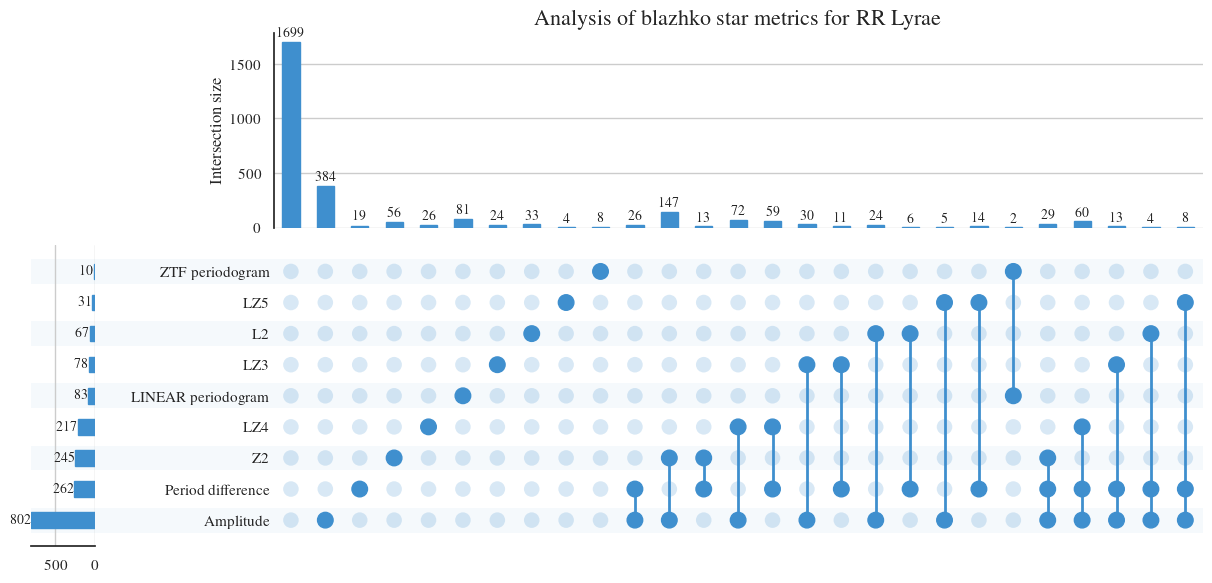

In [24]:
from upsetplot import UpSet
import pandas as pd
import matplotlib.pyplot as plt

# Convert grouped DataFrame to a format for UpSet plot
binary_columns = ['L2', 'Z2', 'LZ3','LZ4','LZ5','LINEAR periodogram', 'ZTF periodogram', 'Amplitude', 'Period difference']
upset_data = grouped.set_index(binary_columns)['counts']

# Create UpSet plot
plt.figure(figsize=(30, 20))
upset = UpSet(upset_data, subset_size='sum', sort_by='degree', facecolor=b2, other_dots_color=0.2, show_counts=True)
upset.plot()
for text in plt.gcf().findobj(plt.Text):  # Find all text objects in the current figure
    if text.get_text().isdigit():  # Filter only numeric count texts
        text.set_fontsize(10)
plt.title("Analysis of blazhko star metrics for RR Lyrae", fontsize=16)
plt.savefig('../images_paper/candidate_metrics.png', dpi=150)
plt.show()


After this refined selection process, we are left with 409 Blazhko candidates (of which 115 are previously deemed Blazhko stars). 

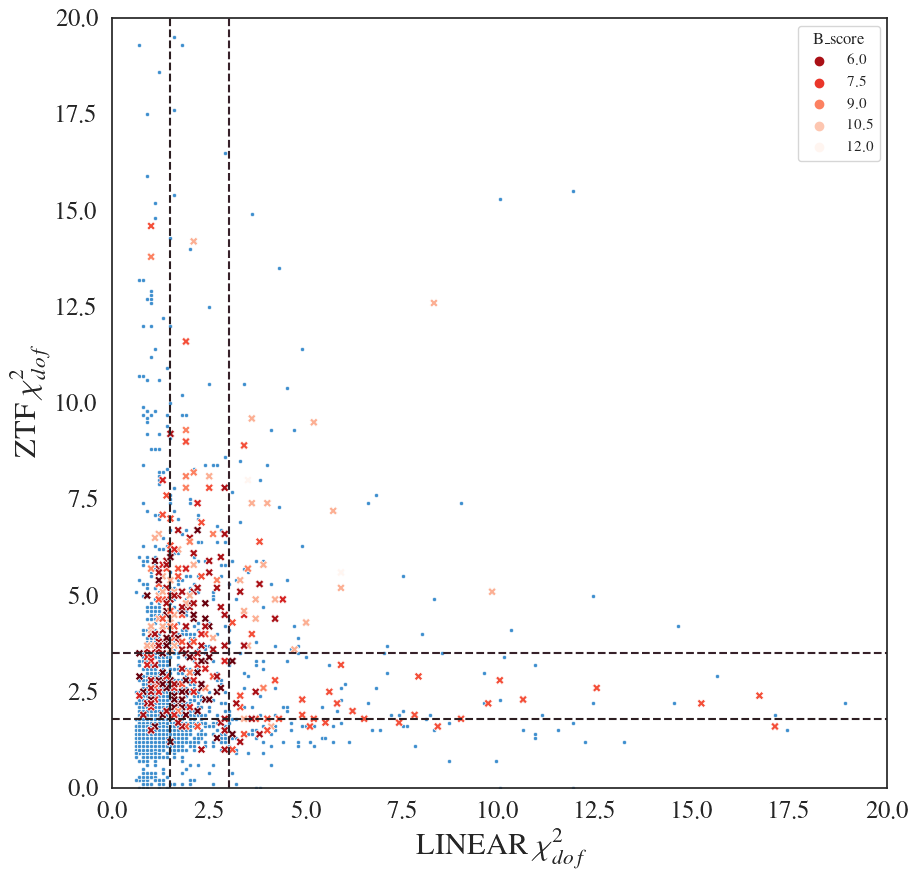

In [15]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(xscale='linear', yscale='linear') 
ax.xaxis.set_tick_params(labelsize=18) 
ax.yaxis.set_tick_params(labelsize=18) 
plt.rc('font', size=24) 


sns.scatterplot(data=lc_analysis, x='L_chi2dofR', y='Zchi2dofR', marker='.', color=b2)
sns.scatterplot(data=blazhko_MASTER, x='L_chi2r', y='Z_chi2r', marker='X', color=or4, palette='Reds_r',hue='B_score')

plt.xlim([0, 20]) # limit of 20, because above 20 there is no point, something is wrong with the data
plt.ylim([0, 20])
plt.xlabel(r'LINEAR $\chi_{dof}^2$', fontproperties=font, fontsize=22)
plt.ylabel(r'ZTF $\chi_{dof}^2$', fontproperties=font,fontsize=22)

plt.plot([1.5, 1.5], [0, 20], ls='--', c=black2)
plt.plot([3.0, 3.0], [0, 20], ls='--', c=black1)
plt.plot([0, 20.0], [1.8, 1.8], ls='--', c=black2)
plt.plot([0, 20.0], [3.5, 3.5], ls='--', c=black1)
plt.savefig('../images_paper/candidate_chi2_overlap.png', dpi=150)

plt.show()

In [59]:
b_inspect = blazhko_MASTER[(blazhko_MASTER['L_chi2r'] < 1.5) & (blazhko_MASTER['Z_chi2r'] < 1.8) & (blazhko_MASTER['Periodogram_f'] != 'L') * (blazhko_MASTER['Periodogram_f'] != 'Z')]

In [60]:
b_inspect

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,dP,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,Periodogram_f,B_score
64,3405178,0.579231,0.579204,256,509,1.0,1.5,1.1,3.8,0.75,1.06,0.00005,0.31,1.7785,1.7319,19.2160,185.1852,-,6.0
155,8799313,0.327560,0.327542,280,785,1.1,1.6,1.3,3.9,0.47,0.40,0.00005,0.07,3.0766,3.0565,42.1941,289.8551,-,5.0
196,10634459,0.684672,0.684787,203,412,1.0,1.5,1.4,3.7,0.61,1.15,0.00017,0.54,1.5282,1.4885,14.7809,35.4170,-,6.0


- the number of stars found in the "forbidden" rectangle of $\chi^2$ selection is in accordance with the number of stars found in the table, everything checks out!